<a href="https://colab.research.google.com/github/adedert/IANNWTF_FinalProject/blob/main/Lunar_Lander.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install swig
!pip install gymnasium[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 35.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2376101 sha256=e977bd1f3f7b7141b712028e3e8e4f37835c327ea039e025e1a6f650589674be
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py


In [2]:
import gymnasium as gym
import numpy as np
from collections import namedtuple, deque
import random
import pickle
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam

Mounted at /content/drive


In [3]:
class DQN(tf.keras.Model):
  def __init__(self, num_actions, lr=0.001):
    super().__init__()

    self.fc1 = tf.keras.layers.Dense(64, activation="relu")
    self.fc2 = tf.keras.layers.Dense(64, activation="relu")
    self.out = tf.keras.layers.Dense(num_actions)

    self.metrics_list = [tf.keras.metrics.Mean(name="loss")]
    self.lr = lr

    self.optimizer = tf.keras.optimizers.Adam(self.lr)

  @property
  def metrics(self):
      return self.metrics_list

  def reset_metrics(self):
      for metric in self.metrics:
          metric.reset_state()

  def call(self, input):
    x = self.fc1(input)
    x = self.fc2(x)
    x = self.out(x)
    return x

In [4]:
class dqn_agent():
  def __init__(self, env_name, erp_size, tau, gamma, learning_rate, double_q, eps_min=0.01, eps_decay=0.99):
    self.env = gym.make(env_name)
    self.num_actions = self.env.action_space.n
    self.state_shape = self.env.observation_space.shape
    self.erp = deque(maxlen=erp_size)
    self.tau = tau
    self.gamma = gamma
    self.epsilon = 1.0
    self.eps_min = eps_min
    self.eps_decay = eps_decay
    self.double_q = double_q
    self.online_network = DQN(self.num_actions, learning_rate)
    self.target_network = DQN(self.num_actions, learning_rate)

    self.online_network(tf.random.uniform(shape=(1,8)))
    self.target_network(tf.random.uniform(shape=(1,8)))

  def get_experiences(self):
    experiences = random.sample(self.erp, k=64)
    states = tf.convert_to_tensor(np.array([e.state for e in experiences if e is not None]),dtype=tf.float32)
    actions = tf.convert_to_tensor(np.array([e.action for e in experiences if e is not None]), dtype=tf.float32)
    rewards = tf.convert_to_tensor(np.array([e.reward for e in experiences if e is not None]), dtype=tf.float32)
    next_states = tf.convert_to_tensor(np.array([e.next_state for e in experiences if e is not None]),dtype=tf.float32)
    done_vals = tf.convert_to_tensor(np.array([e.done for e in experiences if e is not None]).astype(np.uint8),
                                     dtype=tf.float32)
    return (states, actions, rewards, next_states, done_vals)

  def get_action(self, q_values, epsilon=0):
    if random.random() > epsilon:
      return np.argmax(q_values.numpy()[0])
    else:
      return random.choice(np.arange(4))

  def compute_loss(self, experiences):
    states, actions, rewards, next_states, done_vals = experiences
    if self.double_q:
      best_actions = tf.argmax(self.online_network(next_states), axis=1)
      #predict q_vals for next state with target network
      q_vals = self.target_network(next_states)
      eval_q = tf.gather_nd(q_vals, tf.stack([tf.range(best_actions.shape[0]), tf.cast(best_actions, tf.int32)], axis=1))
      y_targets = rewards + (self.gamma * eval_q * (1-done_vals))
    else:
      max_qsa = tf.reduce_max(self.target_network(next_states), axis=-1)
      y_targets = rewards + (self.gamma * max_qsa * (1-done_vals))
    q_values = self.online_network(states)
    q_values = tf.gather_nd(q_values, tf.stack([tf.range(q_values.shape[0]), tf.cast(actions, tf.int32)], axis=1))
    loss = MSE(y_targets, q_values)

    return loss

  @tf.function
  def agent_learn(self, experiences):
    with tf.GradientTape() as tape:
      loss = self.compute_loss(experiences)
    gradients = tape.gradient(loss, self.online_network.trainable_variables)
    self.online_network.optimizer.apply_gradients(zip(gradients, self.online_network.trainable_variables))
    self.polyak_average()

  def polyak_average(self):
    for target_weights, q_network_weights in zip(self.target_network.weights, self.online_network.weights):
      target_weights.assign((1-self.tau) * q_network_weights + self.tau * target_weights)

  def check_update_conditions(self, j, steps_per_update):
    if(j+1) % steps_per_update == 0 and len(self.erp) > 64:
      return True
    else:
      return False

  def get_new_epsilon(self):
    return max(self.eps_min, self.eps_decay * self.epsilon)

  def train(self, num_epochs=2000, max_steps_per_iter=1000, erp_size=100000, steps_per_update=4):

    self.target_network.set_weights(self.online_network.get_weights())
    experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
    points_history = []
    solved = False

    for i in range(num_epochs):

      state, _ = self.env.reset()
      total_points = 0

      for j in range(max_steps_per_iter):

        state_qn = np.expand_dims(state, axis=0)
        q_values = self.online_network(state_qn)
        action = self.get_action(q_values, self.epsilon)
        next_state, reward, done, _, _ = self.env.step(action)

        self.erp.append(experience(state, action, reward, next_state, done))

        update = self.check_update_conditions(j, steps_per_update)

        if update:
          experiences = self.get_experiences()
          self.agent_learn(experiences)

        state = next_state.copy()
        total_points += reward

        if done:
          break

      points_history.append(total_points)
      avg_points = np.mean(points_history[-100:])

      self.epsilon = self.get_new_epsilon()

      print(f"\rEpisode {i+1} | Total point average of the last {100} episodes: {avg_points:.2f}", end="")

      if (i+1) % 100 == 0:
          print(f"\rEpisode {i+1} | Total point average of the last {100} episodes: {avg_points:.2f}")
          if self.double_q:
            self.online_network.save_weights('/content/drive/MyDrive/Lunar Lander/checkpoints/double_dqn_checkpoint' + str(i+1))
          else:
            self.online_network.save_weights('/content/drive/MyDrive/Lunar Lander/checkpoints/dqn_checkpoint' + str(i+1))

      if not solved:
        if(avg_points >= 200):
          print(f"Environment solved in {i+1} episodes!")
          solved = True
          if self.double_q:
            self.online_network.save_weights('/content/drive/MyDrive/Lunar Lander/checkpoints/double_dqn_checkpoint_200')
          else:
            self.online_network.save_weights('/content/drive/MyDrive/Lunar Lander/checkpoints/dqn_checkpoint_200')
      if(avg_points >= 250):
        if self.double_q:
          self.online_network.save_weights('/content/drive/MyDrive/Lunar Lander/checkpoints/double_dqn_checkpoint_250')
          with open('/content/drive/MyDrive/Lunar Lander/double_dqn_rewards.pkl', 'wb') as f:  # open a text file
            pickle.dump(points_history, f)
        else:
          self.online_network.save_weights('/content/drive/MyDrive/Lunar Lander/checkpoints/dqn_checkpoint_250')
          with open('/content/drive/MyDrive/Lunar Lander/dqn_rewards.pkl', 'wb') as f:  # open a text file
            pickle.dump(points_history, f)
        break



In [ ]:
agent = dqn_agent(env_name="LunarLander-v2", erp_size=100000, tau=0.999, gamma=0.99, learning_rate=0.001, double_q=False, eps_min=0.01, eps_decay=0.99)
agent.train()

Episode 100 | Total point average of the last 100 episodes: -160.14
Episode 200 | Total point average of the last 100 episodes: -117.89
Episode 300 | Total point average of the last 100 episodes: -44.55
Episode 400 | Total point average of the last 100 episodes: -10.47
Episode 500 | Total point average of the last 100 episodes: 59.56
Episode 600 | Total point average of the last 100 episodes: 150.83
Episode 700 | Total point average of the last 100 episodes: 3.57
Episode 800 | Total point average of the last 100 episodes: 97.11
Episode 864 | Total point average of the last 100 episodes: 202.66Environment solved in 864 episodes!
Episode 900 | Total point average of the last 100 episodes: 226.77
Episode 1000 | Total point average of the last 100 episodes: 243.79
Episode 1047 | Total point average of the last 100 episodes: 252.81

In [5]:
agent = dqn_agent(env_name="LunarLander-v2", erp_size=100000, tau=0.999, gamma=0.99, learning_rate=0.001, double_q=True, eps_min=0.01, eps_decay=0.99)
agent.train()

Episode 100 | Total point average of the last 100 episodes: -145.68
Episode 200 | Total point average of the last 100 episodes: -99.65
Episode 300 | Total point average of the last 100 episodes: -46.28
Episode 400 | Total point average of the last 100 episodes: 73.32
Episode 500 | Total point average of the last 100 episodes: 186.15
Episode 541 | Total point average of the last 100 episodes: 200.26Environment solved in 541 episodes!
Episode 600 | Total point average of the last 100 episodes: 217.17
Episode 674 | Total point average of the last 100 episodes: 250.19

In [6]:
with open('/content/drive/MyDrive/Lunar Lander/dqn_rewards.pkl', 'rb') as f:  # open a text file
  dqn_rewards = pickle.load(f)
with open('/content/drive/MyDrive/Lunar Lander/double_dqn_rewards.pkl', 'rb') as f:  # open a text file
  double_dqn_rewards = pickle.load(f)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


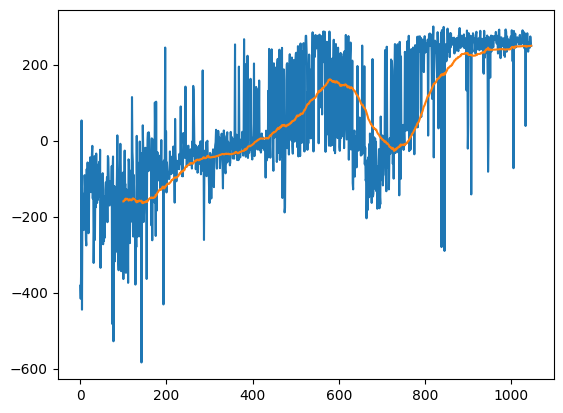

In [15]:
import matplotlib.pyplot as plt
running_reward = []
for i in range(len(dqn_rewards)):
  running_reward.append(np.mean(dqn_rewards[i-100:i]))
running_mean = np.convolve(dqn_rewards, np.ones(100)/100, mode='valid')
plt.plot(dqn_rewards)
plt.plot(running_reward)

In [23]:
test = [1, 2, 3]
np.mean(test[-100:])

2.0